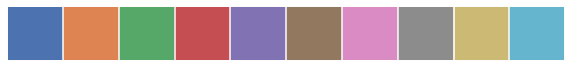

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set('talk')
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)
import json
from pandas.io.json import json_normalize
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [3]:
labels = ['B-ResNet', 'B-DenseNet', 'MSDNet']
results = {
    'b-resnet' : pd.read_json('../edge_test/nuc_2_jetson_b-resnet.json'),
    'b-densenet' : pd.read_json('../edge_test/nuc_2_jetson_b-densenet.json'),
    'msdnet' : pd.read_json('../edge_test/msdnet-local3.json')
}

In [73]:
results['msdnet'].loc[results['msdnet']['sample'] == 7]

,exit,prediction,scores,target,overall time,correct,sample,index_top5
35,0,"[0, 54, 59, 83, 9]","[0.999993681907653, 3.717733989105909e-06, 1.5...",0,20.630320,True,7,0
36,1,"[0, 83, 92, 54, 59]","[0.9999997615814201, 1.787191905577856e-07, 3....",0,12.731603,True,7,0
37,2,"[0, 59, 92, 83, 97]","[0.9999998807907101, 6.909156979872932e-08, 6....",0,10.320455,True,7,0
38,3,"[0, 59, 88, 97, 92]","[1.0, 1.1777865793760611e-08, 2.50921194933084...",0,7.031059,True,7,0
39,4,"[0, 92, 23, 97, 59]","[0.999999284744262, 1.094188561978626e-07, 9.0...",0,6.030881,True,7,0


In [28]:
list(results.keys())

['b-resnet', 'b-densenet', 'msdnet']

In [82]:
timings = np.zeros((4999,4))
for _, row in results['b-resnet'].groupby('sample'):
    if row['sample'].any() != 0:
        timings[_-1] = row['prediction time'].tolist() 

In [87]:
np.cumsum(timings,axis=1).mean(axis=0)

array([ 8.65829554, 16.89964446, 53.15870298, 63.65918415])

In [55]:
overall_time = np.zeros((2,4))
com_time = np.zeros(2)
comp_time = np.zeros((2,4))
for i, net in enumerate(list(results.keys())[:2]):
    for _, row in results[net].groupby('sample'):
        com_time[i] += (row['overall time'].tolist()[0]-row['prediction time'].tolist()[0]-row['preprocess time'].tolist()[0])
        if row['sample'].any() != 0:
            comp_time[i] += row['prediction time'].tolist()
            overall_time[i] += row['overall time'].tolist()

In [56]:
com_time / 5000

array([66.95222606, 66.42057351])

In [57]:
comp_time / 4999

array([[ 8.65829554,  8.24134892, 36.25905852, 10.50048117],
       [10.65091101, 14.32802165, 25.76869358, 18.21592207]])

In [61]:
np.cumsum(comp_time, axis=1) /4999

array([[ 8.65829554, 16.89964446, 53.15870298, 63.65918415],
       [10.65091101, 24.97893266, 50.74762624, 68.96354831]])

In [58]:
overall_time /4999

array([[80.72771915, 80.8230291 , 81.07246793, 91.15593271],
       [82.41661399, 82.50610317, 82.58008511, 96.89830702]])

In [68]:
msd_overall_time = np.zeros(5)
#com_time = 0
#comp_time = np.zeros(4)
for i, net in enumerate(list(results.keys())[2:]):
    for _, row in results[net].groupby('sample'):
        #com_time[i] += (row['overall time'].tolist()[0]-row['prediction time'].tolist()[0]-row['preprocess time'].tolist()[0])
        if row['sample'].any() != 0:
            msd_overall_time += row['overall time'].tolist()

In [70]:
msd_overall_time /4999

array([20.0040949 , 12.67090499, 10.05549511,  7.15916707,  6.03291529])

In [72]:
np.cumsum(msd_overall_time) /4999

array([20.0040949 , 32.67499989, 42.730495  , 49.88966208, 55.92257736])

top-5 accuracy

In [117]:
top5  = { x : np.array(results[x].loc[(results[x]['index_top5'] != -1)].groupby('exit').count()['index_top5'].tolist()) / 5000 for x in results }
top5

{'b-resnet': array([0.738 , 0.8792, 0.9648, 0.9696]),
 'b-densenet': array([0.7862, 0.917 , 0.9452, 0.965 ]),
 'msdnet': array([0.9012, 0.9458, 0.9582, 0.963 , 0.9612])}

In [118]:
top1 = {x : np.array(results[x].loc[(results[x]['correct'] == True)].groupby('exit').count()['correct'].tolist()) / 5000 for x in results }
top1

{'b-resnet': array([0.4394, 0.6684, 0.8698, 0.8826]),
 'b-densenet': array([0.5114, 0.7452, 0.8292, 0.866 ]),
 'msdnet': array([0.7256, 0.8248, 0.853 , 0.8644, 0.864 ])}

In [120]:
combined_top5 = {}
for net in results:
    one_is_right = np.zeros(4)
    if net == 'msdnet':
        one_is_right = np.zeros(5)
    
    for _, d in results[net].groupby('sample'):
        idx = d.index_top5.tolist()
        for n in range(len(idx),0,-1):
            if all(i == -1 for i in idx[:n]):
                one_is_right[n-1] +=1 
    combined_top5[net] = (5000 - one_is_right) / 5000
combined_top5

{'b-resnet': array([0.738 , 0.8948, 0.9762, 0.9824]),
 'b-densenet': array([0.7862, 0.9344, 0.967 , 0.978 ]),
 'msdnet': array([0.9012, 0.9574, 0.9724, 0.978 , 0.9796])}

In [121]:
combined_top1 = {}
for net in results:
    one_is_right = np.zeros(4)
    if net == 'msdnet':
        one_is_right = np.zeros(5)
    for _, d in results[net].groupby('sample'):
        if any(i==0 for i in d.index_top5.tolist()):
            one_is_right += 1
    combined_top1[net] = one_is_right / 5000
combined_top1

{'b-resnet': array([0.9152, 0.9152, 0.9152, 0.9152]),
 'b-densenet': array([0.9132, 0.9132, 0.9132, 0.9132]),
 'msdnet': array([0.9174, 0.9174, 0.9174, 0.9174, 0.9174])}

In [ ]:
exit_wronged = {
    'exit-{}'.format(x) : {
        'count' : 0,
        'samples' : [],
        'overturned by': []
    } for x in range(4)
}
list_of_samples = []
for i, d in results['b-densenet'].groupby('sample'):
    correct = np.array(d.correct.tolist())
    scores = np.array(d.scores.tolist())[:,0]

    for j in range(3):
        if correct[j] == True and correct[j+1:].any() == False and scores[j+1:].any() > scores[j]:
            for p in p.delete(correct)
            print(i,j)
            exit_wronged['exit-{}'.format(j)]['samples'].append(i)
            exit_wronged['exit-{}'.format(j)]['count'] += 1

In [ ]:
exit_wronged

In [ ]:
list_of_samples

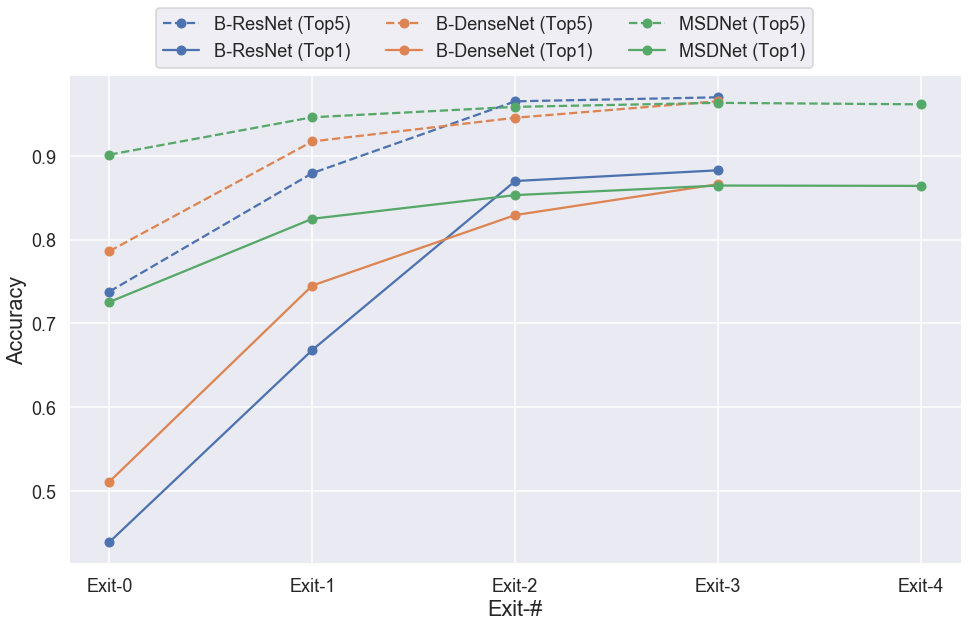

In [150]:
fig, ax = plt.subplots(1,1)
x = np.arange(5)
for i, net in enumerate(results):
    ax.plot(top5[net], '--o', color=current_palette[i])
    ax.plot(top1[net], '-o', color=current_palette[i])
    
    
ax.set_xticks(x)
ax.set_xticklabels(['Exit-{}'.format(x) for x in range(5)])
fig.legend([val for sublist in [['{} (Top5)'.format(x) ]+ ['{} (Top1)'.format(x)] for x in labels] for val in sublist], 
           ncol=3, loc="upper center", fontsize='medium')

ax.set(xlabel='Exit-#', ylabel='Accuracy')
plt.savefig('accuracy-comparison.png')

In [9]:
[['Top1-{}'.format(x)] + ['Top5-{}'.format(x) ]for x in results]


[['Top1-b-resnet', 'Top5-b-resnet'],
 ['Top1-b-densenet', 'Top5-b-densenet'],
 ['Top1-msdnet', 'Top5-msdnet']]

In [132]:
nets = { net : {} for net in results}
for net in results:
    n_exits = 5
    best_exit = np.zeros(n_exits)
    best_score = np.zeros((n_exits,n_exits))
    highscore_incorrect = np.zeros((n_exits,n_exits))
    highscore_correct = np.zeros((n_exits,n_exits))
    worst_mistaken = np.zeros(n_exits)
    for i, d in results[net].groupby('sample'):
        #tmp = d[np.argmax(d.scores.tolist()[0]):1]
        correct = np.array(d.correct.tolist())
        scores = np.array(d.scores.tolist())
        
        
#for n, c in enumerate(correct):
        for n in range(len(correct),0,-1):
            #print(n)
            correct = correct[:n]
            scores = scores[:,:n]
            e_highscore = np.argmax(scores) // n_exits
            #print(scores)
            
            best_score[n-1][e_highscore] +=1
        
            if correct[e_highscore] == False:
                #print(e_highscore)
                highscore_incorrect[n-1][e_highscore] += 1
            else:
                #print(e_highscore)
                highscore_correct[n-1][e_highscore] += 1 
        #worst_mistaken[combined_incorrect] +=1

    nets[net]['best exit scoring'] = best_score
    nets[net]['best score exit incorrect'] = highscore_incorrect
    nets[net]['best score exit correct'] = highscore_correct
nets

{'b-resnet': {'best exit scoring': array([[5000.,    0.,    0.,    0.,    0.],
         [1563., 3437.,    0.,    0.,    0.],
         [ 171., 4829.,    0.,    0.,    0.],
         [ 171., 1392., 3437.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.]]),
  'best score exit incorrect': array([[2803.,    0.,    0.,    0.,    0.],
         [ 843., 1169.,    0.,    0.,    0.],
         [ 100., 1576.,    0.,    0.,    0.],
         [ 100.,  407.,  383.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.]]),
  'best score exit correct': array([[2197.,    0.,    0.,    0.,    0.],
         [ 720., 2268.,    0.,    0.,    0.],
         [  71., 3253.,    0.,    0.,    0.],
         [  71.,  985., 3054.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.]])},
 'b-densenet': {'best exit scoring': array([[5000.,    0.,    0.,    0.,    0.],
         [2527., 2473.,    0.,    0.,    0.],
         [ 424., 4576.,    0.,    0.,    0.],
         [ 424., 2103., 2473.,    0.,    

In [125]:
nets[net]['best score exit incorrect']

array([[1372.,    0.,    0.,    0.,    0.],
       [ 596.,  458.,    0.,    0.,    0.],
       [ 311.,  350.,  209.,    0.,    0.],
       [ 311.,  173.,  137.,  170.,    0.],
       [ 119.,  138.,  145.,  131.,  168.]])

In [143]:
def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox.expanded(1.05,1.4))

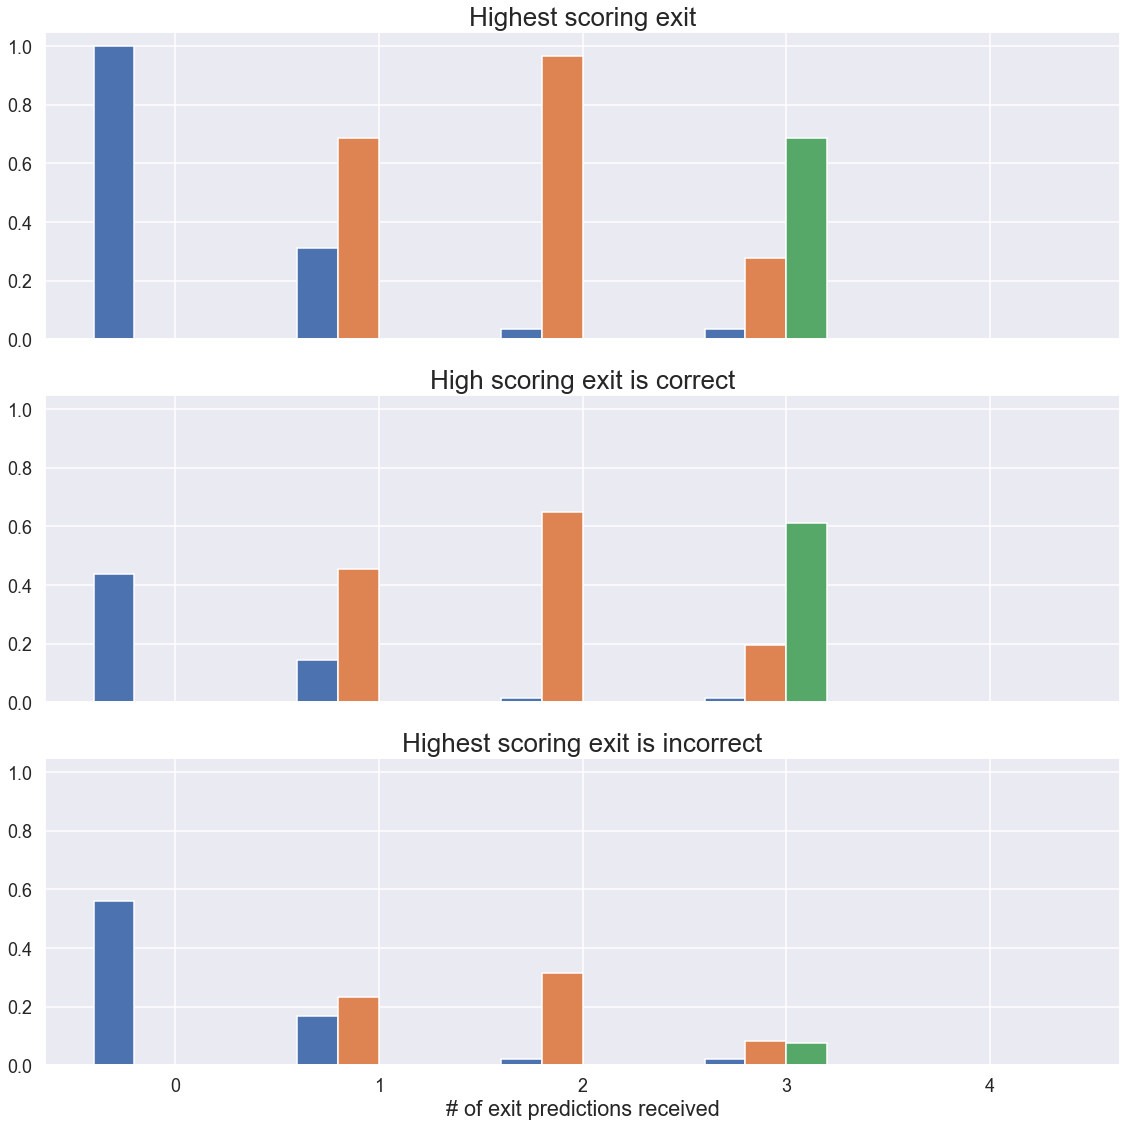

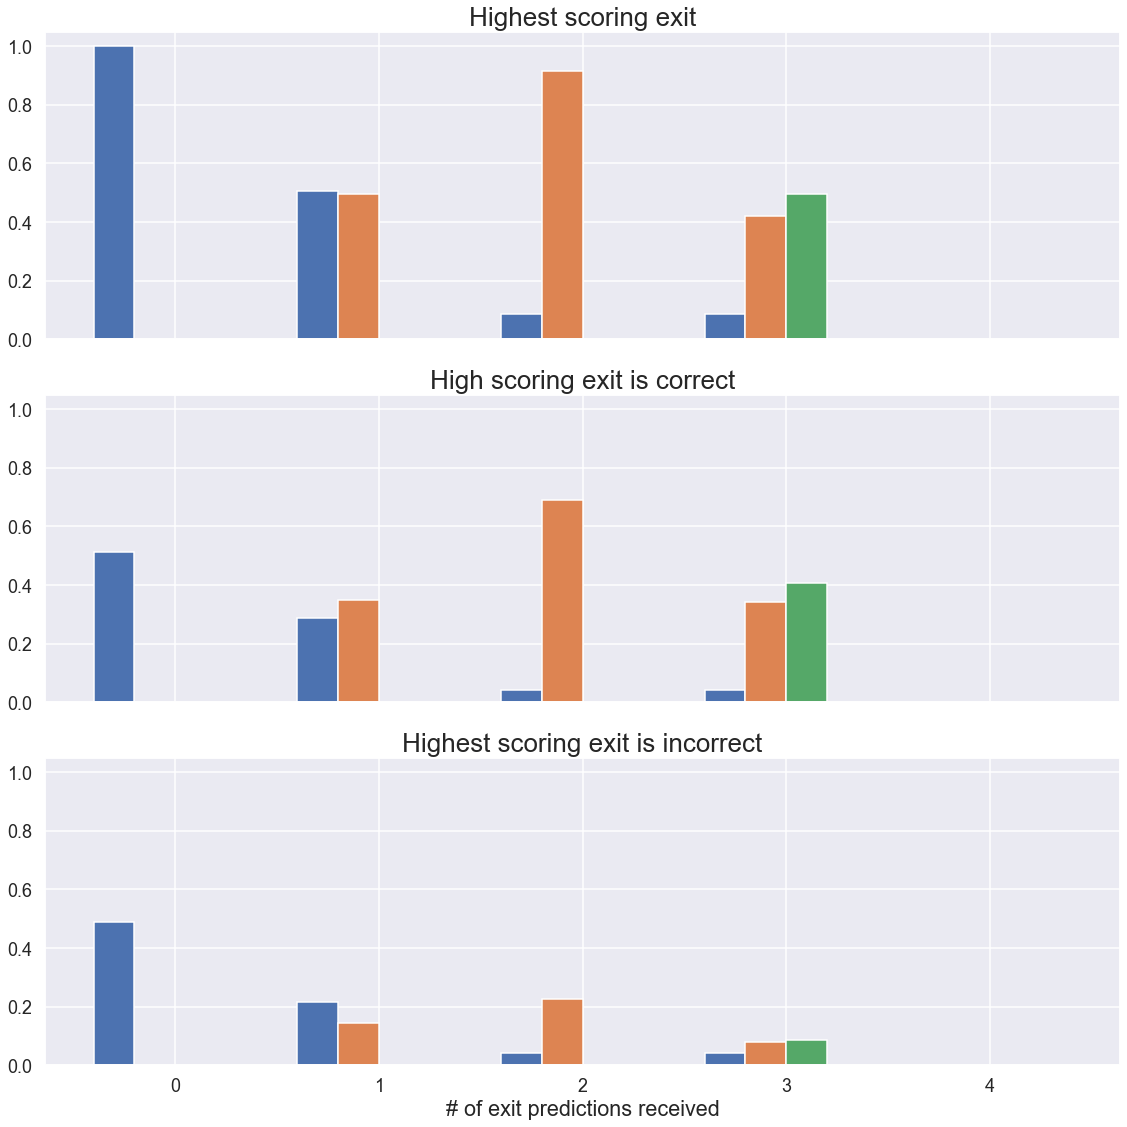

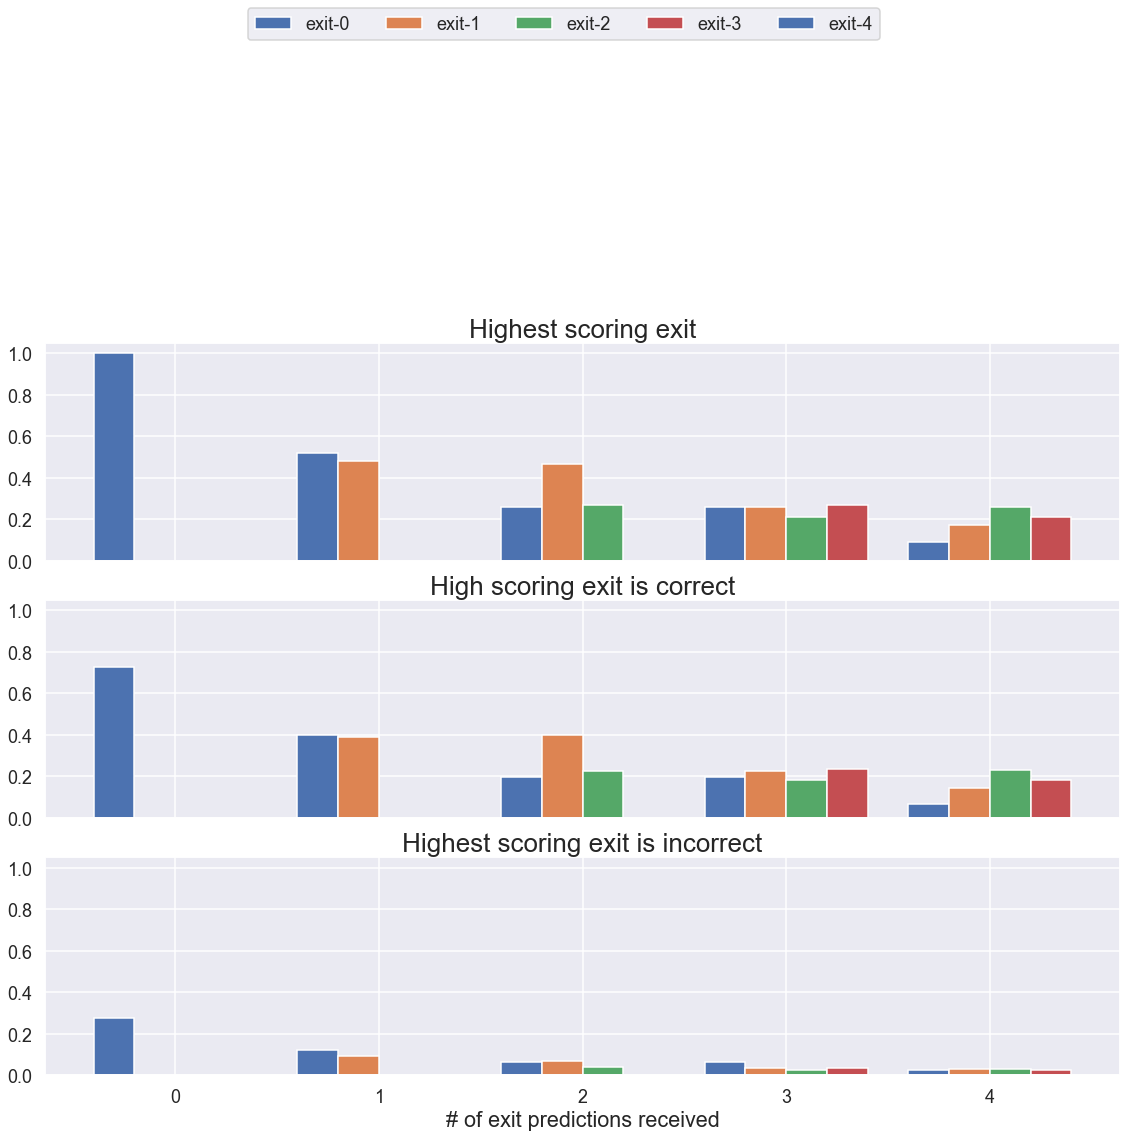

In [140]:
for net in nets:
    fig, axes = plt.subplots(3,1, sharex=True, sharey=True, figsize=(16,16))
    n_exits = 5
    x = np.arange(n_exits)
    width = 0.2
    #ax.bar(x-width, best_exit, width=width)
    #ax.bar(x, best_score, width=width)
    #ax.bar(x+width, score_correct, width=width)
    for index_offset, exit_n in zip([-1.5,-.5,.5,1.5], range(n_exits)):
        axes[0].bar(x+(width*index_offset), nets[net]['best exit scoring'].T[exit_n] /5000, width=width)
        axes[1].bar(x+(width*index_offset), nets[net]['best score exit correct'].T[exit_n] /5000, width=width)
        axes[2].bar(x+(width*index_offset), nets[net]['best score exit incorrect'].T[exit_n] /5000, width=width)

    for ax, title in zip(axes.flat, ['Highest scoring exit', 'High scoring exit is correct', 'Highest scoring exit is incorrect']):
        ax.set_xticks(x)
        ax.set_title(title)
        ax.set_xlabel('# of exit predictions received')
        ax.label_outer()
        #ax.set_xticklabels(label for label in nets[net])


    fig.tight_layout()

    plt.savefig(net + '_correctness.png')
fig.subplots_adjust(top=0.70)   
legend = fig.legend(['exit-{}'.format(x) for x in range(n_exits)], ncol=n_exits, loc="upper center", fontsize='medium')
    
export_legend(legend, filename='exit0-4_legend.png')

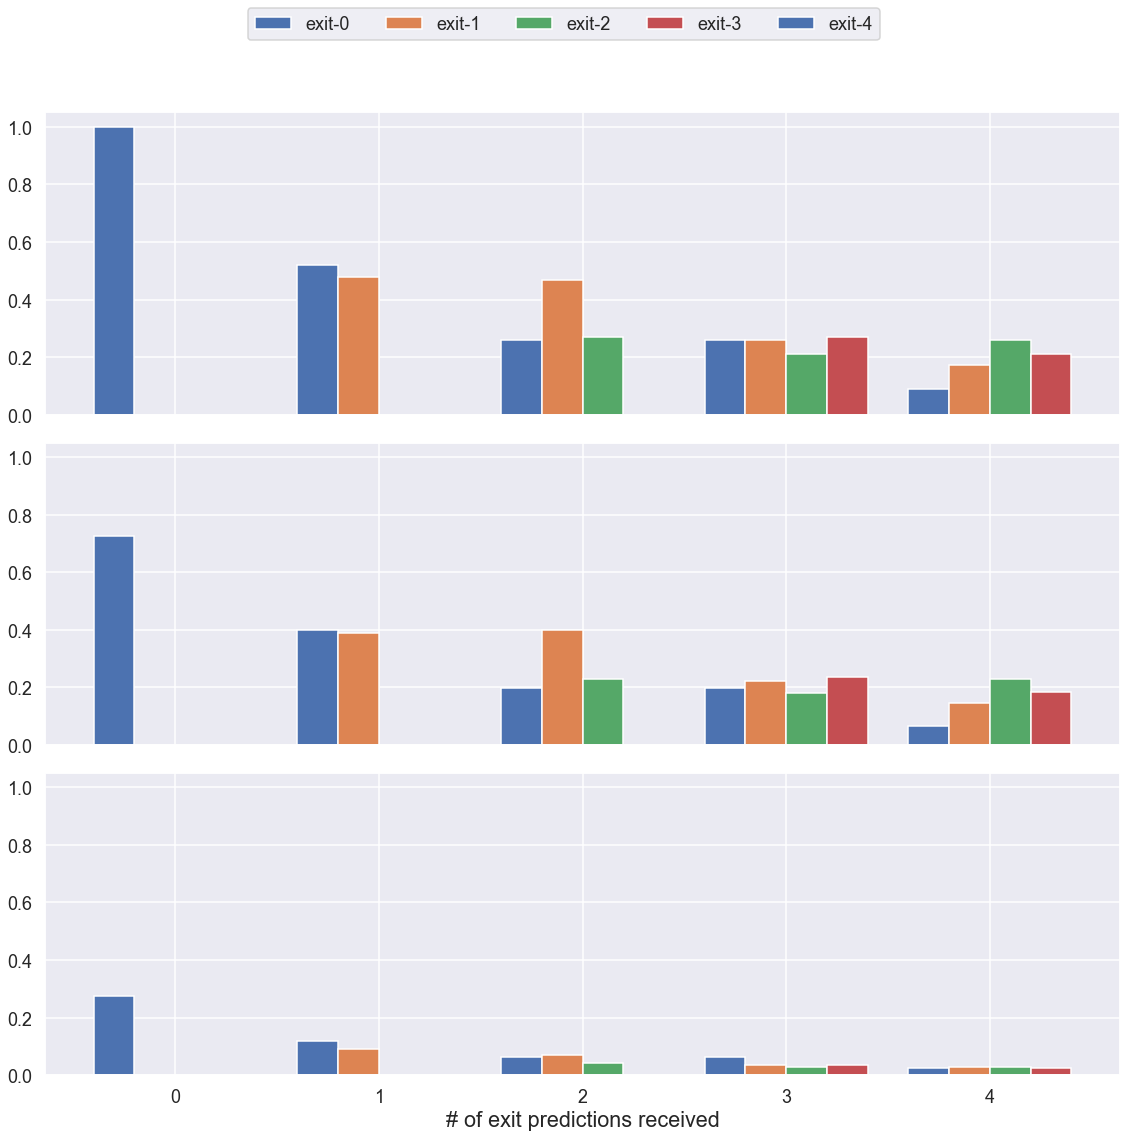

In [146]:
fig, axes = plt.subplots(3,1, sharex=True, sharey=True, figsize=(16,16))
n_exits = 5
x = np.arange(n_exits)
width = 0.2
#ax.bar(x-width, best_exit, width=width)
#ax.bar(x, best_score, width=width)
#ax.bar(x+width, score_correct, width=width)
for index_offset, exit_n in zip([-1.5,-.5,.5,1.5], range(n_exits)):
    axes[0].bar(x+(width*index_offset), nets[net]['best exit scoring'].T[exit_n] /5000, width=width)
    axes[1].bar(x+(width*index_offset), nets[net]['best score exit correct'].T[exit_n] /5000, width=width)
    axes[2].bar(x+(width*index_offset), nets[net]['best score exit incorrect'].T[exit_n] /5000, width=width)

for ax, title in zip(axes.flat, ['Highest scoring exit', 'High scoring exit is correct', 'Highest scoring exit is incorrect']):
    ax.set_xticks(x)
    #ax.set_title(title)
    ax.set_xlabel('# of exit predictions received')
    ax.label_outer()
    #ax.set_xticklabels(label for label in nets[net])


fig.tight_layout()

#plt.savefig(net + '_correctness.png')
fig.subplots_adjust(top=0.90)   
legend = fig.legend(['exit-{}'.format(x) for x in range(n_exits)], ncol=n_exits, loc="upper center", fontsize='medium')
    
export_legend(legend, filename='exit0-4_legend.png')